# Logistic Regression with Scikit-Learn

Logistic regression is a binary classification method (0|1) derived from regression.

Let be y = f(x), x in R -> y = 0,1. The function f cannot be a line, but rather something similar to a sigmoid, which yields the probability of 0 & 1 (the cutoff point is set in 0.5). In fact, the regression line is the input for the sigmoid!

Confusion matrices are used to evaluate the model on test data: real (T or F) vs prediction (T or F):
- TP
- **FN: type II error: these are the really severe errors we'd like to avoid! Image you are sick but the test says you're not...**
- FP - type I error
- TN
   
Metrics derived from the confusion matrix (see definition):
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Missclassification rate = (FP + FN) / (TP + TN + FP + FN)

### Titanic dataset from Kaggle

We predict if passengers survived based on several independent variables.

Note that in this notebook, and in many ML applications, most of the time is spent in exploring and cleaning the dataset. The actual lines for logistic regression training and inference are very few.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [151]:
train = pd.read_csv('data/titanic_train.csv')

In [117]:
test = pd.read_csv('data/titanic_test.csv')

In [4]:
# Class: 1, 2, 3
# SibSp: siblings or spouses aboard
# Parch: parents of children aboard
# Cabin: cabin id/number
# Embarked: S(outhampton), ... (3 ports)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 1. Exploratory analysis

First, we always need to do some profound exploratory analysis.

In [195]:
# Check general information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
male        889 non-null uint8
Q           889 non-null uint8
S           889 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 91.2 KB


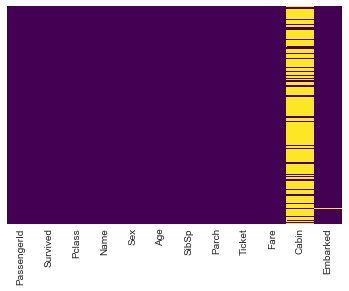

In [114]:
# Check in a heatmap if we have missing data: plot .isnull() = True/False
# .isnull() detects None
# We see that Cabin is quite corrupt/missing
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
# We can set our favourite style
sns.set_style('whitegrid')

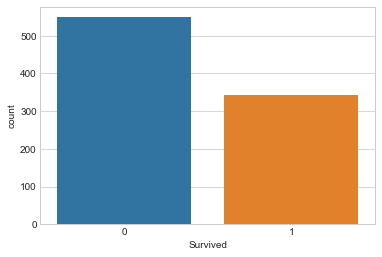

In [10]:
sns.countplot(x='Survived',data=train)

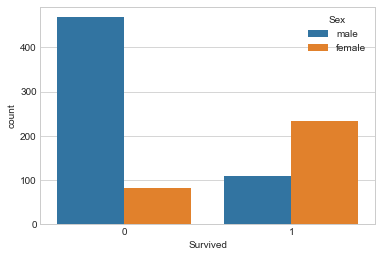

In [12]:
# We add hue='Sex'
# women seem to have survived more than men
sns.countplot(x='Survived',data=train,hue='Sex')

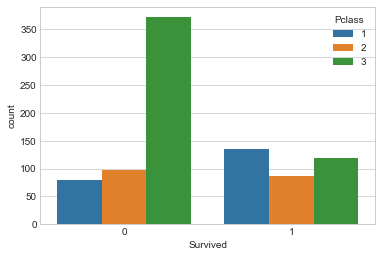

In [14]:
# We add hue='Pclass'
# 3rd class people seem to have died more than the 1st class
sns.countplot(x='Survived',data=train,hue='Pclass')

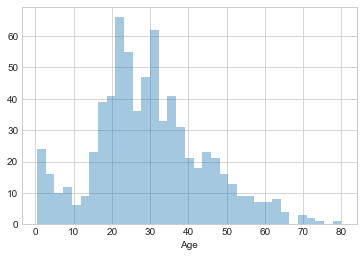

In [17]:
# We plot age distribution
# Since we had several missing data, we need to remove them
# Age distribution seems to be bi-modal: peak in children, peak around 22
sns.distplot(train['Age'].dropna(),kde=False,bins=35)

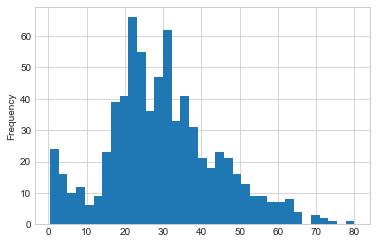

In [18]:
# Another option: pandas-plt
train['Age'].dropna().plot.hist(bins=35)

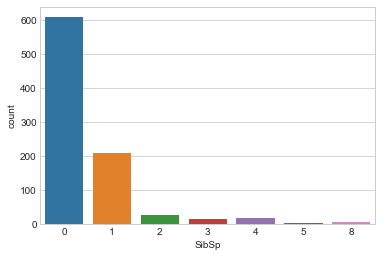

In [23]:
# Count children/spouse
sns.countplot(x='SibSp',data=train)

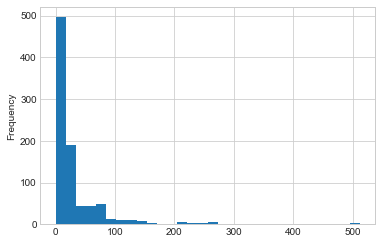

In [26]:
# Check fare distribution
train['Fare'].plot.hist(bins=30)

#### 2. Cleaning Data

Next, we need to clean and prepare our data as much as possible. Usually, a big part of the work goes here.

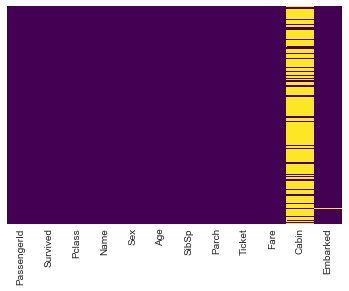

In [113]:
# We plot the heatmap of nulls in the dataframe
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [34]:
# Age is missing in many entries
# We can fill in the cell with the mean age of the corresponding class!
# This is known as 'imputation'

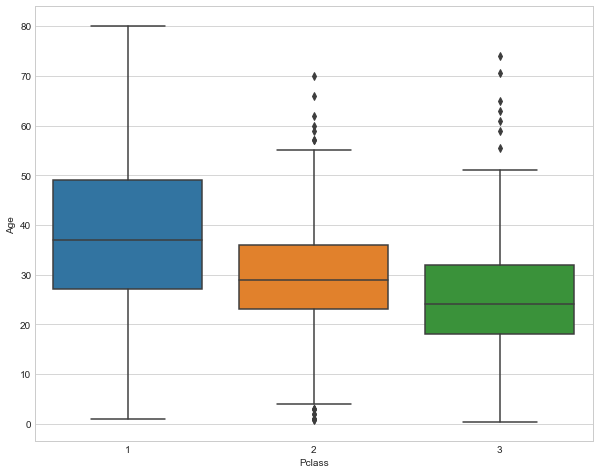

In [36]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Pclass',y='Age',data=train)

In [152]:
# My approach
age_class_1 = train.groupby('Pclass').mean()['Age'][1]
age_class_2 = train.groupby('Pclass').mean()['Age'][2]
age_class_3 = train.groupby('Pclass').mean()['Age'][3]
age_class = {1:age_class_1, 2:age_class_2, 3:age_class_3}
# Define function to apply
def impute_age(d):
    if pd.isnull(d[0]):
        return age_class[d[1]]
    else:
        # We need to return something!
        return d[0]

In [153]:
age_class

{1: 38.233440860215055, 2: 29.877630057803469, 3: 25.140619718309861}

In [154]:
# We return a new column!
tm = train[['Age','Pclass']].apply(modify_age,axis=1)

In [155]:
# Change the column!
train['Age'] = tm

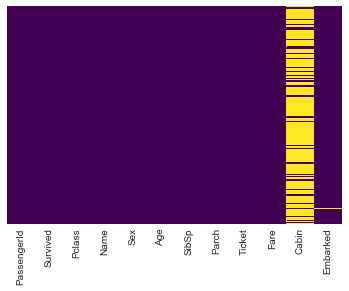

In [156]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [157]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [158]:
# We now drop the column cabin and any other few NAs
train.drop('Cabin',axis=1,inplace=True) # remove column: axis=1
train.dropna(axis=0,inplace=True) # remove any row with NAs: axis=0

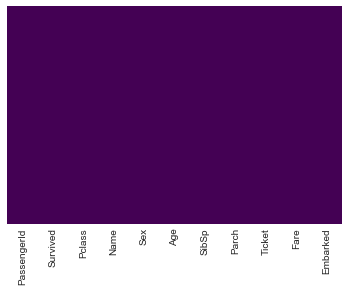

In [159]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [160]:
# Dummy variables must be created for categorical data, eg:
# Sex = male / female -> 0 / 1
# Embark = S / C / ... -> 0 / 1 / ...
# This is done with .get_dummies()

In [161]:
sex_dummy = pd.get_dummies(train['Sex'])

In [162]:
# However, we get one column for wach of the sexes, whereby one value predicts the other
# That is bad...
# To avoid that, we use the option drop_first=True
sex_dummy.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [163]:
sex_dummy = pd.get_dummies(train['Sex'],drop_first=True)

In [164]:
sex_dummy.head()

,male
0,1
1,0
2,0
3,0
4,1


In [165]:
# We do the same for Embarked: get dummy dropping first column
embark_dummy = pd.get_dummies(train['Embarked'],drop_first=True)

In [166]:
embark_dummy.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [167]:
# Append/Concatenate new columns to dataset
train = pd.concat([train,sex_dummy,embark_dummy],axis=1)

In [168]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [172]:
# Remove the columns we're not going to use
train.drop(['Sex','Name','Sex','Ticket','Embarked'],axis=1,inplace=True)

In [174]:
train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
886,887,0,2,27.00000,0,0,13.00,1,0,1
887,888,1,1,19.00000,0,0,30.00,0,0,1
888,889,0,3,25.14062,1,2,23.45,0,0,1
889,890,1,1,26.00000,0,0,30.00,1,0,0
890,891,0,3,32.00000,0,0,7.75,1,1,0


In [175]:
# We further remove the PassengerId, because it has no predictive value
train.drop(['PassengerId'],axis=1,inplace=True)

In [176]:
# Note that Pclass is also categorical!
# We can convert it to dummy variable
# We check later the difference of doing it or not
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


#### 3. Train and Infer

The least amount of the time goes in the training & inferece jobs; most of the time is spent in exploring the data, and specially, in cleaning and preparing the dataset.

We must apply the same cleaning processing to our `test` data frame. However, for simplicity, we use the dataset `train` only and split it.

In [180]:
# We take our X & y variables and split them
y = train['Survived']
X = train.drop('Survived',axis=1)

In [181]:
from sklearn.model_selection import train_test_split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [188]:
X_test.shape

(267, 8)

In [182]:
from sklearn.linear_model import LogisticRegression

In [183]:
logmodel = LogisticRegression()

In [184]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [185]:
predictions = logmodel.predict(X_test)

In [191]:
# It doesn't make much sense plotting a scatterplot with classifications
# Instead, we get a classification matrix/report
from sklearn.metrics import classification_report

In [192]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       163
          1       0.82      0.65      0.73       104

avg / total       0.81      0.81      0.80       267



In [194]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions))

[[148  15]
 [ 36  68]]


#### Possible Improvements

- Train with the complete train data frame and test with the test
- Feature engineering: extract information from names (Dr., Mrs., etc.), cabin
- Test what happens if Pclass is converted to be dummy